In [1]:
import respy as rp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
from scipy.stats import lognorm, norm

In [35]:
mu, sigma = 0, 1
log_dist = lognorm(scale=np.exp(mu), s=sigma)
nor_dist = norm(loc=mu, scale=sigma)

In [45]:
x = np.linspace(log_dist.ppf(0.01), log_dist.ppf(0.99), 100)
x[:5]

array([0.09765173, 0.20010448, 0.30255723, 0.40500997, 0.50746272])

Text(0.5, 0, 'x')

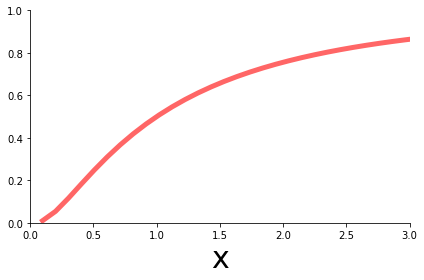

In [52]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, log_dist.cdf(x), 'r-', lw=5, alpha=0.6, label='lognorm pdf')
ax.set_ylim(0, 1)
ax.set_xlim(0, 3)
ax.set_xlabel('x')

In [54]:
y = 0.5
log_dist.cdf(y)

0.24410859578558275

In [56]:
nor_dist.cdf(np.log(y))

0.24410859578558275

(0, 2)

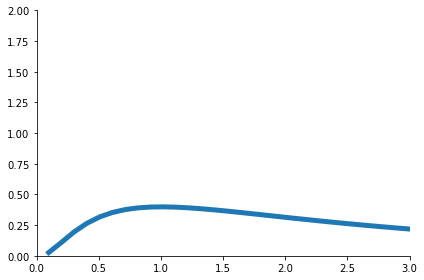

In [50]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, nor_dist.pdf(np.log(x)))
ax.set_xlim(0, 3)
ax.set_ylim(0, 2)
